In [1]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import maxflow
import argparse
from matplotlib.pyplot import figure
from numpy import asarray
from numpy import save
import imutils

%matplotlib inline

## Input directories

In [2]:
image_dir = r"C:\Users\lucki\WORK\UMBC\DAA\DAA_641-Spring_22-Project_1\test"
src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
sink = cv2.imread(os.path.join(image_dir, 'target.jpg'))
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))

In [3]:
def compute_edge_weights(src, sink):
    """
    Computes edge weights based on matching quality cost.
    :param src: image to be blended (foreground)
    :param sink: background image
    """
    edge_weights = np.zeros((src.shape[0], src.shape[1], 2))

    # Create shifted versions of the matrices for vectorized operations.
    src_left_shifted = np.roll(src, -1, axis=1)
    sink_left_shifted = np.roll(sink, -1, axis=1)
    src_up_shifted = np.roll(src, -1, axis=0)
    sink_up_shifted = np.roll(sink, -1, axis=0)

    # Assign edge weights.
    # For numerical stability, avoid divide by 0.
    eps = 1e-10

    # Right neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_left_shifted - sink_left_shifted, 
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_left_shifted, dtype=np.float) +
                         np.square(sink - sink_left_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 0] = weight / (norm_factor + eps)

    # Bottom neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_up_shifted - sink_up_shifted,
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_up_shifted, dtype=np.float) +
                         np.square(sink - sink_up_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 1] = weight / (norm_factor + eps)
    
    return edge_weights

In [4]:
assert (src.shape == sink.shape), f"Source and sink dimensions must be the same: {str(src.shape)} != {str(sink.shape)}"

# Create the graph
graph = maxflow.Graph[float]()
# Add the nodes. node_ids has the identifiers of the nodes in the grid.
node_ids = graph.add_grid_nodes((src.shape[0], src.shape[1]))

edge_weights = compute_edge_weights(src, sink)

In [5]:
# Add non-terminal edges
patch_height = src.shape[0]
patch_width = src.shape[1]
for row_idx in range(patch_height):
    for col_idx in range(patch_width):
        # right neighbor
        if col_idx + 1 < patch_width:
            weight = edge_weights[row_idx, col_idx, 0]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx][col_idx + 1],
                           weight,
                           weight)

        # bottom neighbor
        if row_idx + 1 < patch_height:
            weight = edge_weights[row_idx, col_idx, 1]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx + 1][col_idx],
                           weight,
                           weight)

        # Add terminal edge capacities for the pixels constrained to
        # belong to the source/sink.
        if np.array_equal(mask[row_idx, col_idx, :], [0, 255, 255]):
            graph.add_tedge(node_ids[row_idx][col_idx], 0, np.inf)
        elif np.array_equal(mask[row_idx, col_idx, :], [255, 128, 0]):
            graph.add_tedge(node_ids[row_idx][col_idx], np.inf, 0)

In [6]:
# Compute max flow / min cut.
flow = graph.maxflow()

In [7]:
sgm = graph.get_grid_segments(node_ids)

In [8]:
flow, sgm.shape

(706.3616882780407, (480, 640))

In [9]:
sgm[100]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## Get the segments of the nodes in the grid.

In [10]:
canvas = np.zeros(sink.shape, dtype=np.uint8)

In [11]:
sink[sgm] = src[sgm]

image = sink

# Part 2.c

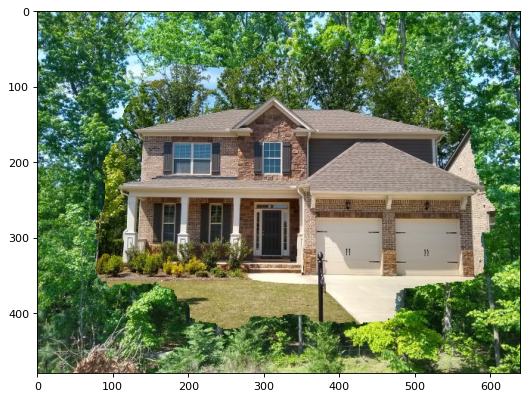

In [12]:
rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
figure(figsize=(10, 6), dpi=80)
plt.imshow(rgb_img);

plt.savefig(os.path.join(image_dir, '2.c.png'))

In [13]:
src.shape[:2]

(480, 640)

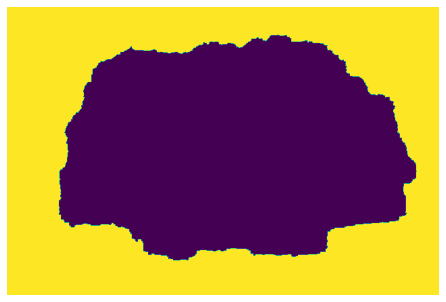

In [14]:
# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))

# Show the result.
fig = plt.figure(frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)


# img2 = img2.T
# img2 = cv2.flip(img2, 0)
# img2 = cv2.rotate(img2, cv2.cv2.ROTATE_90_CLOCKWISE)

ax.imshow(img2, aspect='auto')
fig.savefig("{}/temp.png".format(image_dir))

# Part 2.b

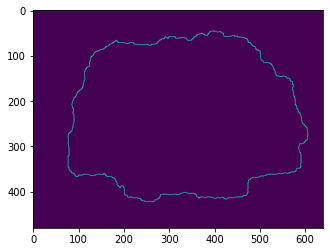

In [15]:
img = cv2.imread("{}/temp.png".format(image_dir))
os.remove("{}/temp.png".format(image_dir))
# resize image
resized_image = cv2.resize(img, src.shape[:2][::-1]) 
# Convert to graycsale
img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
plt.imshow(edges)
# Display Canny Edge Detection Image
cv2.imwrite('{}/2.b.png'.format(image_dir), edges)
# save to npy file
save('{}/2.b.npy'.format(image_dir), edges)

# Part 2.a

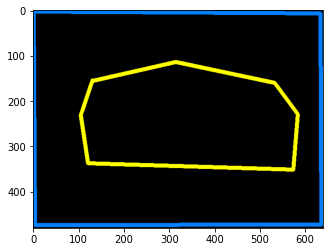

In [16]:
# cv2.imshow('thresh', thresh)
plt.imshow(cv2.cvtColor(mask , cv2.COLOR_BGR2RGB))

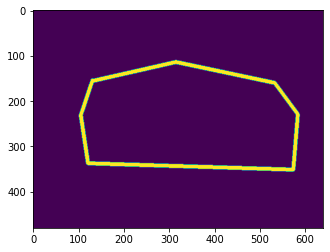

In [17]:
# Testing
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))
image = mask
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([22, 93, 0], dtype="uint8")
upper = np.array([45, 255, 255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

plt.imshow(mask)
    
# mask = cv2.imread(os.path.join(image_dir, 'mask.png'))
# hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
# # retval, thresh_crop = cv2.threshold(hsv * 255, thresh=20, maxval=255, type=cv2.THRESH_BINARY)
# plt.imshow(hsv)

In [18]:
retval, thresh_crop = cv2.threshold(mask, thresh=254, maxval=255, type=cv2.THRESH_BINARY)

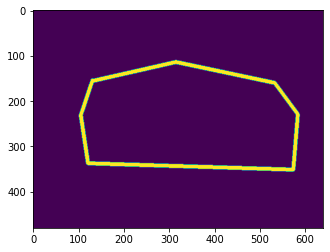

In [19]:
plt.imshow(thresh_crop)

In [20]:
img_canny = cv2.Canny(thresh_crop, 10, 10)
img_dilate = cv2.dilate(img_canny, None, iterations=1)
img_erode = cv2.erode(img_dilate, None, iterations=1)

mask = np.full(thresh_crop.shape, 255, "uint8")
contours, hierarchies = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    cv2.drawContours(mask, [cnt], -1, 0, -1)

new_mask = cv2.cvtColor(cv2.bitwise_not(mask) , cv2.COLOR_BGR2RGB)

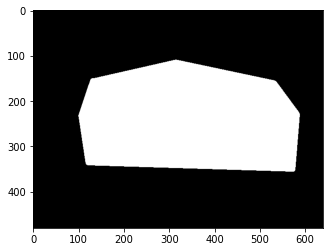

In [21]:
plt.imshow(new_mask);

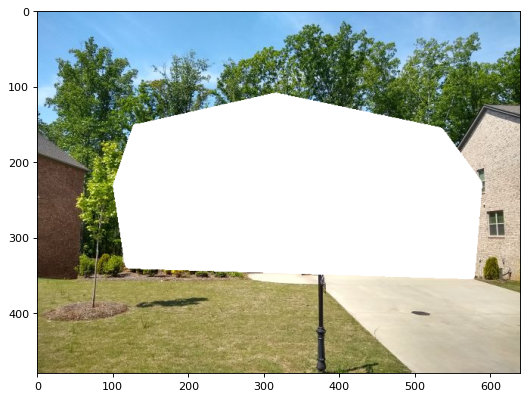

In [22]:
gray = cv2.cvtColor(new_mask, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
sink = cv2.imread(os.path.join(image_dir, 'target.jpg'))
# Remove background using bitwise-and operation
result = cv2.bitwise_and(src, src, mask=thresh)
result[thresh==0] = [255,255,255] # Turn background white

# cv2.imshow('thresh', thresh)
result_img = cv2.cvtColor(result , cv2.COLOR_BGR2RGB)
figure(figsize=(10, 6), dpi=80)
plt.imshow(result_img);

In [23]:
_, mask = cv2.threshold(gray, thresh=10, maxval=255, type=cv2.THRESH_BINARY)
im_thresh_gray = cv2.bitwise_and(gray, mask)

res = cv2.bitwise_and(src,src,mask = mask)
cropped_src = cv2.cvtColor(res , cv2.COLOR_BGR2RGB)

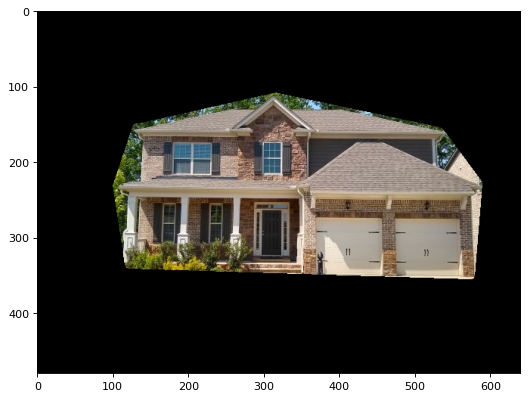

In [24]:
# cv2.imshow('thresh', thresh)
figure(figsize=(10, 6), dpi=80)
plt.imshow(cropped_src);

In [25]:
dst = cv2.addWeighted(sink, 1.0, cropped_src, 1.0, 0)

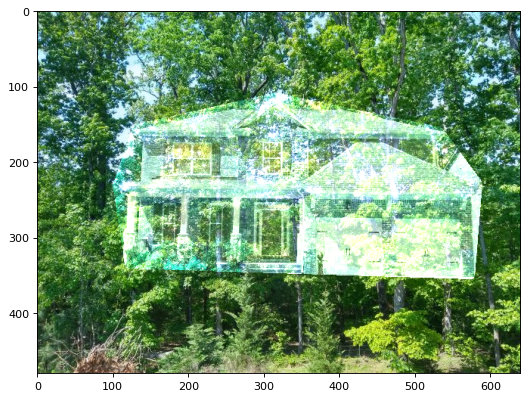

In [26]:
figure(figsize=(10, 6), dpi=80)
plt.imshow(cv2.cvtColor(dst , cv2.COLOR_BGR2RGB));

In [27]:
cv2.imwrite('{}/2.a.png'.format(image_dir), dst)

True

### ADjency Matrix

# Plotting of ndarray

In [28]:
# import cv2
# import numpy as np

# dst = cv2.addWeighted(src, 0.5, sink, 0.7, 0)

# img_arr = np.hstack((src, sink))
# # Show the result.
# plt.imshow(dst)
# plt.show()

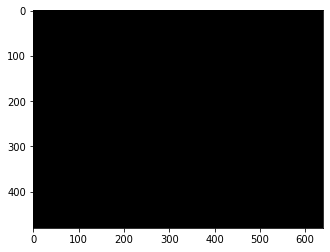

In [29]:
rgb_img = cv2.cvtColor(canvas , cv2.COLOR_BGR2RGB)
# figure(figsize=(8, 6), dpi=80)
plt.imshow(rgb_img)
# plt.savefig('src[sgm] = canvas[sgm].png')
plt.show()

In [30]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# Some legacy ouputs

- 1. sink[sgm] = src[sgm] `# OG`
- 2. src[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # source cutted`
- 3. sink[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # target cutted`

In [31]:

# """
# How to use several calls to ``add_grid_edges`` and ``add_grid_tedges`` to create
# a flow network.
# """

# import numpy as np
# import maxflow
# import networkx as nx

# import matplotlib.pyplot as plt


# def plot_graph_2d(graph, nodes_shape, plot_weights=True, plot_terminals=True, font_size=7):

#     X, Y = np.mgrid[:nodes_shape[0], :nodes_shape[1]]
#     aux = np.array([Y.ravel(), X[::-1].ravel()]).T
#     positions = {i: v for i, v in enumerate(aux)}
#     positions['s'] = (-1, nodes_shape[0] / 2.0 - 0.5)
#     positions['t'] = (nodes_shape[1], nodes_shape[0] / 2.0 - 0.5)

#     try:
#         nxgraph = graph.get_nx_graph()
#     except Exception as e:
#         print(e)
#     if not plot_terminals:
#         nxgraph.remove_nodes_from(['s', 't'])

#     plt.clf()
#     nx.draw(nxgraph, pos=positions)

#     if plot_weights:
#         edge_labels = {}
#         for u, v, d in nxgraph.edges(data=True):
#             edge_labels[(u, v)] = d['weight']
#         nx.draw_networkx_edge_labels(nxgraph,
#                                      pos=positions,
#                                      edge_labels=edge_labels,
#                                      label_pos=0.3,
#                                      font_size=font_size)

#     plt.axis('equal')
#     plt.show()
#     plt.savefig('run.png')

# def create_graph():
#     g = maxflow.Graph[float]()
#     nodeids = g.add_grid_nodes((5, 5))

#     # Edges pointing backwards (left, left up and left down) with infinite
#     # capacity
#     structure = np.array(
#         [[np.inf, 0, 0],
#          [np.inf, 0, 0],
#          [np.inf, 0, 0]]
#     )
#     g.add_grid_edges(nodeids, structure=structure, symmetric=False)

#     # Set a few arbitrary weights
#     weights = np.array([[100, 110, 120, 130, 140]]).T + np.array([0, 2, 4, 6, 8])

#     # Edges pointing right
#     structure = np.zeros((3, 3))
#     structure[1, 2] = 1
#     g.add_grid_edges(nodeids, structure=structure, weights=weights, symmetric=False)

#     # Edges pointing up
#     structure = np.zeros((3, 3))
#     structure[0, 1] = 1
#     g.add_grid_edges(nodeids, structure=structure, weights=weights+100, symmetric=False)

#     # Edges pointing down
#     structure = np.zeros((3, 3))
#     structure[2, 1] = 1
#     g.add_grid_edges(nodeids, structure=structure, weights=weights+200, symmetric=False)

#     # Source node connected to leftmost non-terminal nodes.
#     left = nodeids[:, 0]
#     g.add_grid_tedges(left, np.inf, 0)
#     # Sink node connected to rightmost non-terminal nodes.
#     right = nodeids[:, -1]
#     g.add_grid_tedges(right, 0, np.inf)

#     return nodeids, g


# nodeids, g = create_graph()

# plot_graph_2d(g, nodeids.shape)

# g.maxflow()
# print(g.get_grid_segments(nodeids))